# 투자 데이터 분석 (Phase 2)

## 목차
1. 데이터 로드
2. 환율-코스피 듀얼축 차트 + 롤링상관
   - 2-1. [보완] 시차(Lag) 상관분석
3. 종목별 수익률 비교 + 거래량
   - 3-1. [보완] 위험조정 성과 지표 (샤프비율, MDD)
4. 뉴스 키워드 빈도 추이
   - 4-1. [보완] 뉴스 감성분석
5. 미국-한국 상관분석
6. 섹터별 분석 (신규)
7. 요약 통계

---
**데이터 현황 (2025-12-02 업데이트)**
- 주가: 38,319건 (27종목, 2020-01-02 ~ 현재)
- 경제지표: 4,447건
- 뉴스: 962건

**종목 구성**
- 한국 지수/ETF: 코스피, 코스닥, KODEX200
- 한국 개별(16개): 삼성전자, SK하이닉스, LG에너지솔루션, 삼성바이오, 현대차, KB금융, POSCO홀딩스, NAVER, 카카오, HYBE, SM, JYP, 크래프톤, 엔씨소프트, CJ ENM, CGV
- 미국(8개): S&P500, 나스닥, VIX, QQQ, SPY, DIA, TLT, GLD

In [2]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats  # 통계 검정용 추가
warnings.filterwarnings('ignore')

# 스타일 설정 (한글 폰트 제거 - 영어만 사용)
plt.style.use('seaborn-v0_8-whitegrid')

print('Library loaded')

Library loaded


## 1. 데이터 로드

In [3]:
# 경로 설정
DATA_DIR = 'R:/00-1_data_processed'
OUTPUT_DIR = 'R:/03_outputs'

# 데이터 로드
stock_df = pd.read_csv(f'{DATA_DIR}/stock_processed.csv', encoding='utf-8-sig')
economy_df = pd.read_csv(f'{DATA_DIR}/economy_processed.csv', encoding='utf-8-sig')
news_df = pd.read_csv(f'{DATA_DIR}/news_processed.csv', encoding='utf-8-sig')

# 날짜 변환
stock_df['date'] = pd.to_datetime(stock_df['date'])
economy_df['date'] = pd.to_datetime(economy_df['date'])
news_df['date'] = pd.to_datetime(news_df['date'])

print(f'Stock: {len(stock_df)}건')
print(f'Economy: {len(economy_df)}건')
print(f'News: {len(news_df)}건')

Stock: 125건
Economy: 171건
News: 962건


In [ ]:
# 데이터 미리보기
print('=== Stock 데이터 ===')
print(stock_df[['date', 'name', 'ticker', 'close', 'log_return']].head(10))
print(f'\n총 종목 수: {stock_df["name"].nunique()}개')
print('\n종목 목록:')
for name in sorted(stock_df['name'].unique()):
    print(f'  - {name}')

In [5]:
# 경제지표 미리보기
print('=== Economy 데이터 ===')
print(economy_df[['date', 'indicator', 'value', 'pct_1d']].head(10))
print('\n지표 목록:', economy_df['indicator'].unique())

=== Economy 데이터 ===
        date indicator  value  pct_1d
0 2025-11-07      금 시세    NaN     NaN
1 2025-11-08      금 시세    NaN     NaN
2 2025-11-09      금 시세    NaN     NaN
3 2025-11-10      금 시세    NaN     NaN
4 2025-11-11      금 시세    NaN     NaN
5 2025-11-12      금 시세    NaN     NaN
6 2025-11-13      금 시세    NaN     NaN
7 2025-11-14      금 시세    NaN     NaN
8 2025-11-15      금 시세    NaN     NaN
9 2025-11-16      금 시세    NaN     NaN

지표 목록: ['금 시세' '기준금리' '두바이유 가격' '원/달러 환율' '원/엔 환율' '원/유로 환율' '콜금리']


## 2. 환율-코스피 듀얼축 차트 + 롤링상관

In [6]:
# 코스피 데이터 추출
kospi = stock_df[stock_df['ticker'] == '^KS11'][['date', 'close']].copy()
kospi.columns = ['date', 'kospi']
kospi = kospi.set_index('date')

# 환율 데이터 추출
usd = economy_df[economy_df['indicator'] == '원/달러 환율'][['date', 'value']].copy()
usd.columns = ['date', 'usd_krw']
usd['usd_krw'] = pd.to_numeric(usd['usd_krw'], errors='coerce')
usd = usd.set_index('date')

# 데이터 병합
merged = kospi.join(usd, how='inner')
merged = merged.dropna()

print(f'병합 데이터: {len(merged)}건')
merged.head()

병합 데이터: 25건


,kospi,usd_krw
date,,
2025-11-06,4026.449951,1447.0
2025-11-07,3953.760010,1445.6
2025-11-08,3953.760010,1445.6
2025-11-09,3953.760010,1445.6
2025-11-10,4073.239990,1454.0


Statistical Test: KOSPI vs USD/KRW Correlation
Correlation: -0.2861
p-value: 0.1655
Significance (0.05): Not Significant


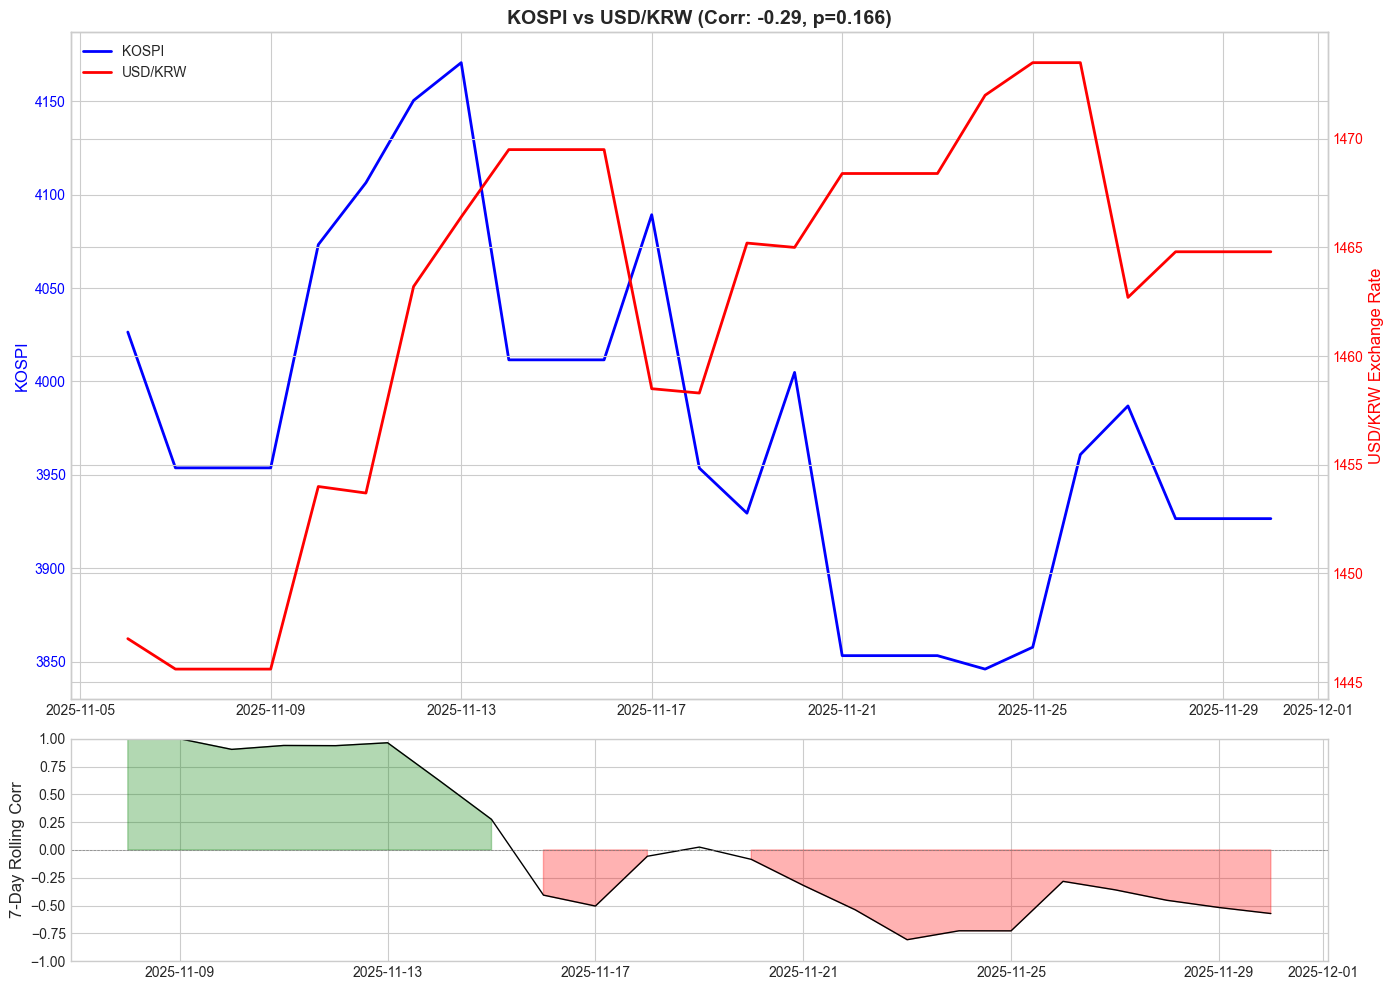


Saved: R:/03_outputs/chart1_kospi_usd.png


In [7]:
# 롤링 상관계수 계산 (7일)
merged['rolling_corr'] = merged['kospi'].rolling(window=7, min_periods=3).corr(merged['usd_krw'])

# ========== [보완] 통계적 유의성 검정 ==========
# 전체 기간 상관계수 + p-value
overall_corr, p_value = stats.pearsonr(merged['kospi'], merged['usd_krw'])
print('='*50)
print('Statistical Test: KOSPI vs USD/KRW Correlation')
print('='*50)
print(f'Correlation: {overall_corr:.4f}')
print(f'p-value: {p_value:.4f}')
print(f'Significance (0.05): {"Significant" if p_value < 0.05 else "Not Significant"}')
print('='*50)

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})

# 상단: 듀얼축 차트
ax1 = axes[0]
ax2 = ax1.twinx()

line1 = ax1.plot(merged.index, merged['kospi'], 'b-', linewidth=2, label='KOSPI')
line2 = ax2.plot(merged.index, merged['usd_krw'], 'r-', linewidth=2, label='USD/KRW')

ax1.set_ylabel('KOSPI', color='blue', fontsize=12)
ax2.set_ylabel('USD/KRW Exchange Rate', color='red', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

# 범례
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
ax1.set_title(f'KOSPI vs USD/KRW (Corr: {overall_corr:.2f}, p={p_value:.3f})', 
              fontsize=14, fontweight='bold')

# 하단: 롤링 상관계수
ax3 = axes[1]
ax3.fill_between(merged.index, merged['rolling_corr'], 0, 
                 where=merged['rolling_corr'] >= 0, color='green', alpha=0.3)
ax3.fill_between(merged.index, merged['rolling_corr'], 0, 
                 where=merged['rolling_corr'] < 0, color='red', alpha=0.3)
ax3.plot(merged.index, merged['rolling_corr'], 'k-', linewidth=1)
ax3.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax3.set_ylabel('7-Day Rolling Corr', fontsize=12)
ax3.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart1_kospi_usd.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR}/chart1_kospi_usd.png')

## 2-1. [보완] 시차(Lag) 상관분석

환율 변화가 코스피에 선행하는지, 후행하는지 분석합니다.

Lag Correlation Analysis Result
Strongest correlation: Lag -4 days, Corr -0.5612
Interpretation: USD/KRW leads KOSPI by 4 day(s)


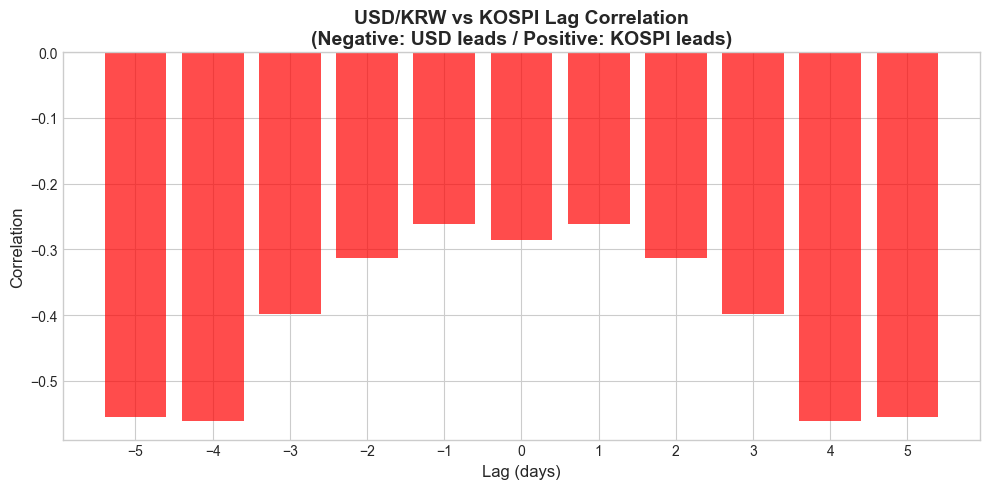

In [8]:
# ========== [보완] 시차(Lag) 상관분석 ==========
# 환율이 코스피를 선행하는지 분석

lag_range = range(-5, 6)  # -5일 ~ +5일
lag_correlations = []

for lag in lag_range:
    if lag < 0:
        corr = merged['usd_krw'].iloc[:lag].corr(merged['kospi'].iloc[-lag:])
    elif lag > 0:
        corr = merged['usd_krw'].iloc[lag:].corr(merged['kospi'].iloc[:-lag])
    else:
        corr = merged['usd_krw'].corr(merged['kospi'])
    lag_correlations.append(corr)

# 시각화
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(lag_range, lag_correlations, color=['red' if c < 0 else 'green' for c in lag_correlations], alpha=0.7)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Lag (days)', fontsize=12)
ax.set_ylabel('Correlation', fontsize=12)
ax.set_title('USD/KRW vs KOSPI Lag Correlation\n(Negative: USD leads / Positive: KOSPI leads)', fontsize=14, fontweight='bold')
ax.set_xticks(list(lag_range))

# 최대 상관 시차 표시
max_corr_idx = np.argmax(np.abs(lag_correlations))
max_lag = list(lag_range)[max_corr_idx]
max_corr = lag_correlations[max_corr_idx]

print('='*50)
print('Lag Correlation Analysis Result')
print('='*50)
print(f'Strongest correlation: Lag {max_lag} days, Corr {max_corr:.4f}')
if max_lag < 0:
    print(f'Interpretation: USD/KRW leads KOSPI by {abs(max_lag)} day(s)')
elif max_lag > 0:
    print(f'Interpretation: KOSPI leads USD/KRW by {max_lag} day(s)')
else:
    print('Interpretation: Move together (no lag)')
print('='*50)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart1_1_lag_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. 종목별 수익률 비교 + 거래량

In [9]:
# 삼성전자 vs SK하이닉스
samsung = stock_df[stock_df['ticker'] == '005930.KS'][['date', 'close', 'volume', 'log_return']].copy()
samsung.columns = ['date', 'samsung_close', 'samsung_vol', 'samsung_ret']
samsung = samsung.set_index('date')

hynix = stock_df[stock_df['ticker'] == '000660.KS'][['date', 'close', 'volume', 'log_return']].copy()
hynix.columns = ['date', 'hynix_close', 'hynix_vol', 'hynix_ret']
hynix = hynix.set_index('date')

# 병합
semi = samsung.join(hynix, how='inner').dropna()

# 누적 수익률 계산
semi['samsung_cum'] = (1 + semi['samsung_ret']).cumprod() - 1
semi['hynix_cum'] = (1 + semi['hynix_ret']).cumprod() - 1

print(f'반도체 데이터: {len(semi)}건')
semi.tail()

반도체 데이터: 24건


,samsung_close,samsung_vol,samsung_ret,hynix_close,hynix_vol,hynix_ret,samsung_cum,hynix_cum
date,,,,,,,,
2025-11-26,102800.0,22558915,0.034640,524000.0,5375315,0.009588,0.028682,-0.129777
2025-11-27,103500.0,17744725,0.006786,544000.0,3838344,0.037458,0.035663,-0.097181
2025-11-28,100500.0,17711155,-0.029414,530000.0,3034702,-0.026072,0.005200,-0.120719
2025-11-29,100500.0,15292277,0.000000,530000.0,2680138,0.000000,0.005200,-0.120719
2025-11-30,100500.0,15292277,0.000000,530000.0,2680138,0.000000,0.005200,-0.120719


## 3-1. [보완] 위험조정 성과 지표

샤프비율, 최대낙폭(MDD) 등 위험을 고려한 성과 지표를 계산합니다.

Risk-Adjusted Performance Metrics
Metric                       Samsung        SK Hynix
------------------------------------------------------------
Cumulative Return              0.52%         -12.07%
Annualized Vol                41.21%          58.58%
Sharpe Ratio                    0.25           -2.07
Max Drawdown (MDD)            -8.90%         -17.31%

Interpretation Guide:
- Sharpe Ratio: Higher is better (risk-adjusted return)
  > 1.0: Excellent, 0.5~1.0: Good, < 0.5: Average
- MDD: Closer to 0 is better (max loss from peak)
  Within -10%: Stable, Beyond -20%: High Risk


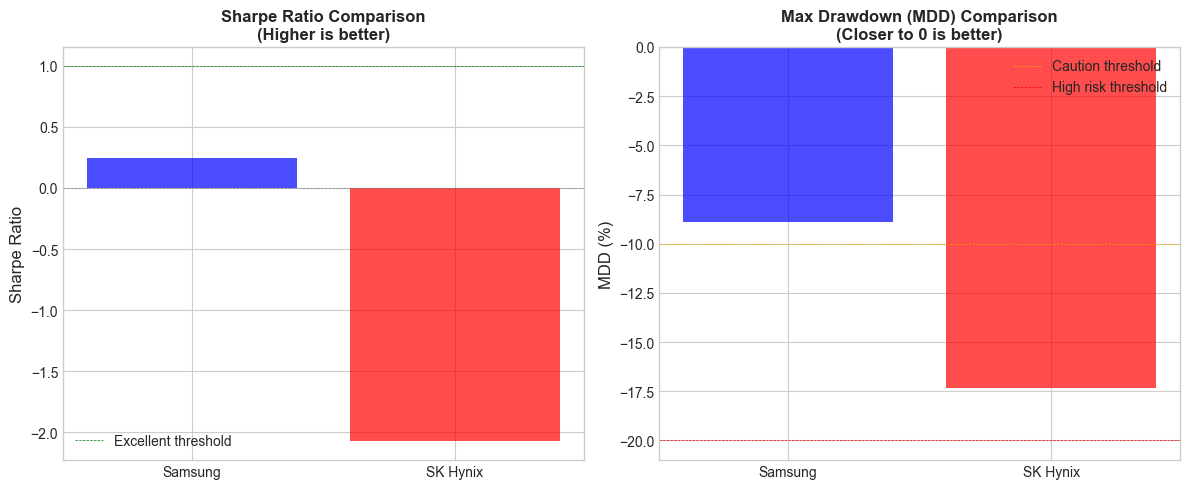


Saved: R:/03_outputs/chart2_1_risk_metrics.png


In [10]:
# ========== [보완] 위험조정 성과 지표 ==========

def calculate_sharpe_ratio(returns, risk_free_rate=0.035, periods=252):
    """
    샤프비율 계산
    - returns: 일별 수익률 시리즈
    - risk_free_rate: 무위험 수익률 (연간, 기본값 3.5%)
    - periods: 연간 거래일 수
    """
    excess_return = returns.mean() * periods - risk_free_rate
    volatility = returns.std() * np.sqrt(periods)
    return excess_return / volatility if volatility != 0 else 0

def calculate_mdd(cumulative_returns):
    """
    최대낙폭(MDD) 계산
    - cumulative_returns: 누적 수익률 시리즈 (1 + 수익률 형태)
    """
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# 누적 자산 가치 계산 (1에서 시작)
semi['samsung_value'] = (1 + semi['samsung_ret']).cumprod()
semi['hynix_value'] = (1 + semi['hynix_ret']).cumprod()

# 지표 계산
samsung_sharpe = calculate_sharpe_ratio(semi['samsung_ret'])
hynix_sharpe = calculate_sharpe_ratio(semi['hynix_ret'])
samsung_mdd = calculate_mdd(semi['samsung_value'])
hynix_mdd = calculate_mdd(semi['hynix_value'])

# 변동성 (연환산)
samsung_vol = semi['samsung_ret'].std() * np.sqrt(252) * 100
hynix_vol = semi['hynix_ret'].std() * np.sqrt(252) * 100

# 결과 출력
print('='*60)
print('Risk-Adjusted Performance Metrics')
print('='*60)
print(f'{"Metric":<20} {"Samsung":>15} {"SK Hynix":>15}')
print('-'*60)
print(f'{"Cumulative Return":<20} {semi["samsung_cum"].iloc[-1]*100:>14.2f}% {semi["hynix_cum"].iloc[-1]*100:>14.2f}%')
print(f'{"Annualized Vol":<20} {samsung_vol:>14.2f}% {hynix_vol:>14.2f}%')
print(f'{"Sharpe Ratio":<20} {samsung_sharpe:>15.2f} {hynix_sharpe:>15.2f}')
print(f'{"Max Drawdown (MDD)":<20} {samsung_mdd*100:>14.2f}% {hynix_mdd*100:>14.2f}%')
print('='*60)

# 해석
print('\nInterpretation Guide:')
print('- Sharpe Ratio: Higher is better (risk-adjusted return)')
print('  > 1.0: Excellent, 0.5~1.0: Good, < 0.5: Average')
print('- MDD: Closer to 0 is better (max loss from peak)')
print('  Within -10%: Stable, Beyond -20%: High Risk')

# 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 샤프비율 비교
ax1 = axes[0]
bars1 = ax1.bar(['Samsung', 'SK Hynix'], [samsung_sharpe, hynix_sharpe], 
                color=['blue', 'red'], alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax1.axhline(y=1, color='green', linestyle='--', linewidth=0.5, label='Excellent threshold')
ax1.set_ylabel('Sharpe Ratio', fontsize=12)
ax1.set_title('Sharpe Ratio Comparison\n(Higher is better)', fontsize=12, fontweight='bold')
ax1.legend()

# MDD 비교
ax2 = axes[1]
bars2 = ax2.bar(['Samsung', 'SK Hynix'], [samsung_mdd*100, hynix_mdd*100], 
                color=['blue', 'red'], alpha=0.7)
ax2.axhline(y=-10, color='orange', linestyle='--', linewidth=0.5, label='Caution threshold')
ax2.axhline(y=-20, color='red', linestyle='--', linewidth=0.5, label='High risk threshold')
ax2.set_ylabel('MDD (%)', fontsize=12)
ax2.set_title('Max Drawdown (MDD) Comparison\n(Closer to 0 is better)', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart2_1_risk_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR}/chart2_1_risk_metrics.png')

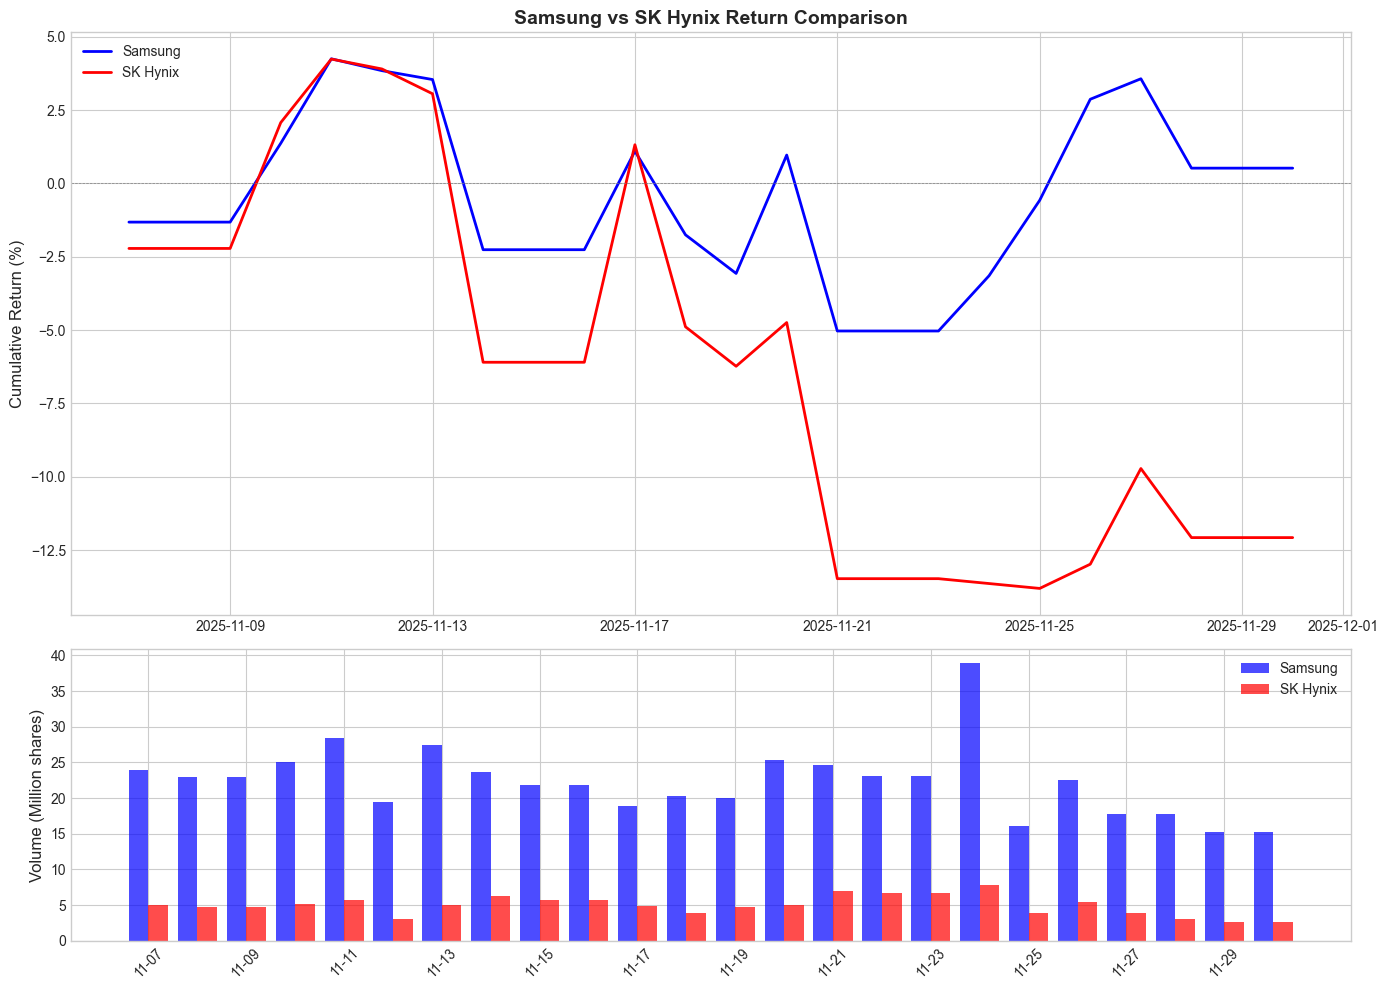


Saved: R:/03_outputs/chart2_semiconductor.png


In [11]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# 상단: 누적 수익률
ax1 = axes[0]
ax1.plot(semi.index, semi['samsung_cum'] * 100, 'b-', linewidth=2, label='Samsung')
ax1.plot(semi.index, semi['hynix_cum'] * 100, 'r-', linewidth=2, label='SK Hynix')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
ax1.legend(loc='upper left')
ax1.set_title('Samsung vs SK Hynix Return Comparison', fontsize=14, fontweight='bold')

# 하단: 거래량
ax2 = axes[1]
width = 0.4
x = range(len(semi))
ax2.bar([i - width/2 for i in x], semi['samsung_vol'] / 1e6, width, label='Samsung', color='blue', alpha=0.7)
ax2.bar([i + width/2 for i in x], semi['hynix_vol'] / 1e6, width, label='SK Hynix', color='red', alpha=0.7)
ax2.set_ylabel('Volume (Million shares)', fontsize=12)
ax2.legend(loc='upper right')

# x축 날짜 설정
tick_positions = list(range(0, len(semi), max(1, len(semi)//10)))
ax2.set_xticks(tick_positions)
ax2.set_xticklabels([semi.index[i].strftime('%m-%d') for i in tick_positions], rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart2_semiconductor.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR}/chart2_semiconductor.png')

## 4. 뉴스 키워드 빈도 추이

In [12]:
# 키워드별 일간 기사 수
news_count = news_df.groupby(['date', 'keyword']).size().unstack(fill_value=0)
print('키워드별 기사 수:')
print(news_count.sum())

키워드별 기사 수:
keyword
경제     235
금리      18
반도체    231
부동산    243
코스피    220
환율      15
dtype: int64


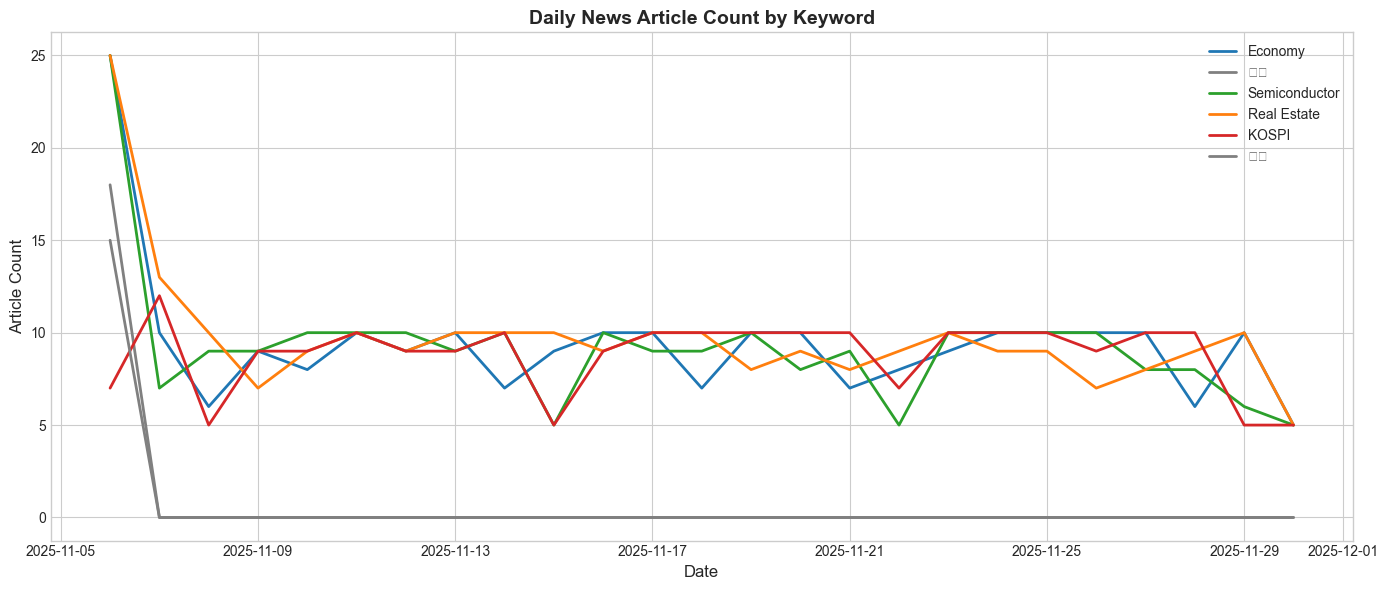


Saved: R:/03_outputs/chart3_news_frequency.png


In [13]:
# 시각화
fig, ax = plt.subplots(figsize=(14, 6))

# 키워드 영어 매핑
keyword_eng = {'경제': 'Economy', '부동산': 'Real Estate', '반도체': 'Semiconductor', '코스피': 'KOSPI'}
colors = {'경제': '#1f77b4', '부동산': '#ff7f0e', '반도체': '#2ca02c', '코스피': '#d62728'}

for keyword in news_count.columns:
    label = keyword_eng.get(keyword, keyword)
    ax.plot(news_count.index, news_count[keyword], 
            linewidth=2, label=label, color=colors.get(keyword, 'gray'))

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Article Count', fontsize=12)
ax.set_title('Daily News Article Count by Keyword', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart3_news_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR}/chart3_news_frequency.png')

## 4-1. [보완] 뉴스 감성분석 (키워드 기반)

뉴스 제목의 긍정/부정 키워드를 분석하여 시장 심리를 파악합니다.

News Sentiment Analysis Result
Total articles: 962
Positive: 207
Neutral: 649
Negative: 106
Avg sentiment score: 0.109


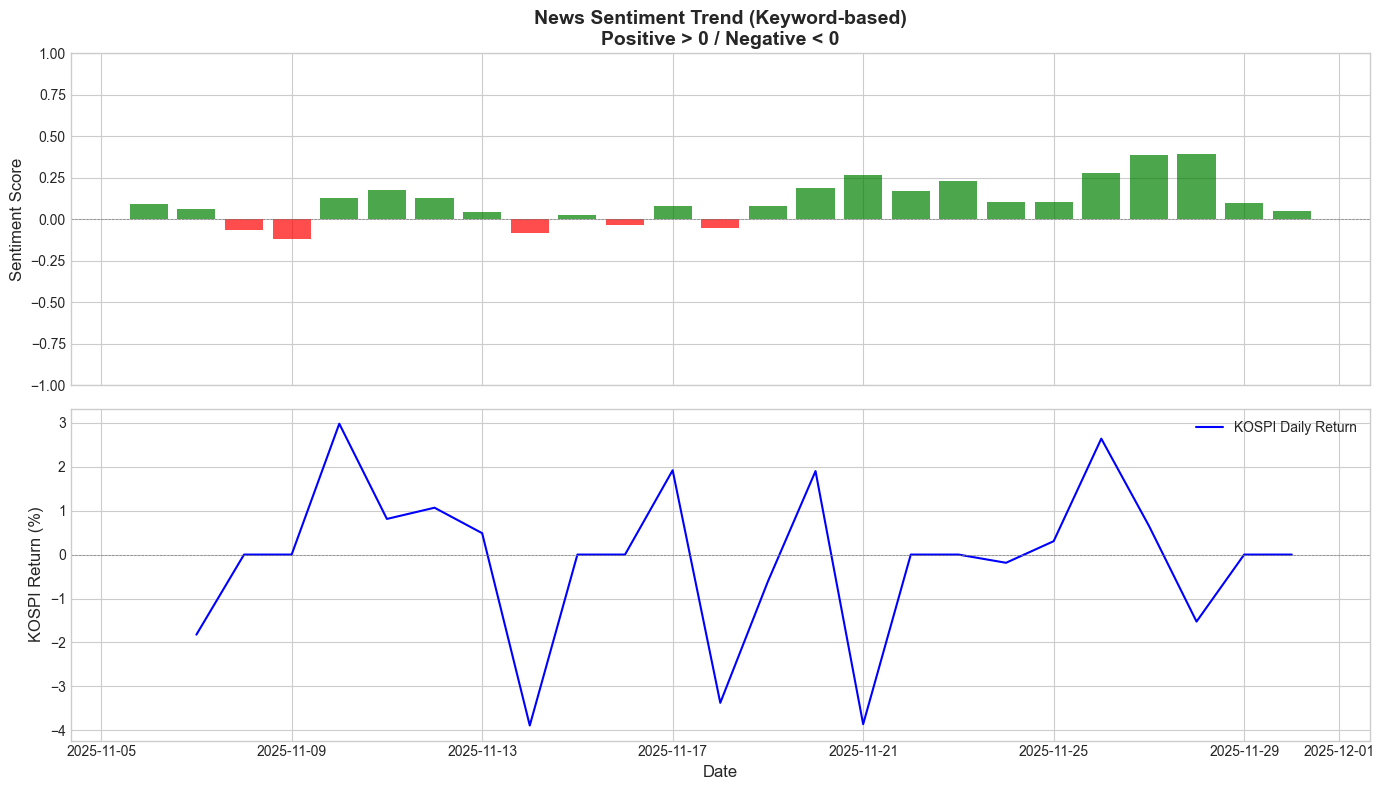


Sentiment-Return Correlation
Correlation: nan, p-value: nan
Interpretation: No significant correlation

Saved: R:/03_outputs/chart3_1_sentiment.png


In [14]:
# ========== [보완] 뉴스 감성분석 ==========
# 키워드 기반 간단한 감성분석 (외부 라이브러리 불필요)

# 금융/경제 도메인 감성 사전
positive_words = [
    '상승', '급등', '호재', '강세', '반등', '회복', '돌파', '최고', '호황',
    '성장', '증가', '확대', '개선', '기대', '긍정', '흑자', '매수', '상향',
    '사상최고', '신고가', '랠리', '상승세', '호실적', '순매수'
]

negative_words = [
    '하락', '급락', '폭락', '약세', '위기', '충격', '우려', '불안', '적자',
    '감소', '축소', '악화', '부진', '침체', '하향', '매도', '손실', '리스크',
    '공포', '패닉', '폭풍', '최저', '순매도', '하락세'
]

def analyze_sentiment(text):
    """
    텍스트의 감성 점수 계산
    반환값: -1(부정) ~ +1(긍정)
    """
    if pd.isna(text):
        return 0
    
    text = str(text)
    pos_count = sum(1 for word in positive_words if word in text)
    neg_count = sum(1 for word in negative_words if word in text)
    
    total = pos_count + neg_count
    if total == 0:
        return 0
    return (pos_count - neg_count) / total

# 뉴스 제목에 감성분석 적용
news_df['sentiment'] = news_df['title'].apply(analyze_sentiment)

# 일별 평균 감성 점수
daily_sentiment = news_df.groupby('date')['sentiment'].mean()

print('='*50)
print('News Sentiment Analysis Result')
print('='*50)
print(f'Total articles: {len(news_df)}')
print(f'Positive: {(news_df["sentiment"] > 0).sum()}')
print(f'Neutral: {(news_df["sentiment"] == 0).sum()}')
print(f'Negative: {(news_df["sentiment"] < 0).sum()}')
print(f'Avg sentiment score: {news_df["sentiment"].mean():.3f}')
print('='*50)

# 시각화: 감성 추이 + 코스피 비교
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 상단: 일별 감성 점수
ax1 = axes[0]
colors = ['green' if s >= 0 else 'red' for s in daily_sentiment.values]
ax1.bar(daily_sentiment.index, daily_sentiment.values, color=colors, alpha=0.7)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax1.set_ylabel('Sentiment Score', fontsize=12)
ax1.set_title('News Sentiment Trend (Keyword-based)\nPositive > 0 / Negative < 0', fontsize=14, fontweight='bold')
ax1.set_ylim(-1, 1)

# 하단: 코스피 수익률과 비교
kospi_ret = stock_df[stock_df['ticker'] == '^KS11'][['date', 'log_return']].copy()
kospi_ret = kospi_ret.set_index('date')

ax2 = axes[1]
ax2.plot(kospi_ret.index, kospi_ret['log_return'] * 100, 'b-', linewidth=1.5, label='KOSPI Daily Return')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax2.set_ylabel('KOSPI Return (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart3_1_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

# 감성과 수익률 상관관계
sentiment_df = daily_sentiment.reset_index()
sentiment_df.columns = ['date', 'sentiment']
kospi_ret_df = kospi_ret.reset_index()

merged_sentiment = pd.merge(sentiment_df, kospi_ret_df, on='date', how='inner')

if len(merged_sentiment) > 5:
    corr, p_val = stats.pearsonr(merged_sentiment['sentiment'], merged_sentiment['log_return'])
    print(f'\nSentiment-Return Correlation')
    print(f'Correlation: {corr:.4f}, p-value: {p_val:.4f}')
    if p_val < 0.05:
        print(f'Interpretation: {"Positive" if corr > 0 else "Negative"} correlation exists')
    else:
        print('Interpretation: No significant correlation')

print(f'\nSaved: {OUTPUT_DIR}/chart3_1_sentiment.png')

## 5. 미국-한국 상관분석

In [ ]:
# 주요 지수 추출 (전체 종목 포함)
# 한국 + 미국 지수/ETF
tickers_to_compare = {
    # 한국 지수
    '^KS11': 'KOSPI',
    '^KQ11': 'KOSDAQ',
    '069500.KS': 'KODEX200',
    # 미국 지수
    '^GSPC': 'S&P500',
    '^IXIC': 'NASDAQ',
    '^VIX': 'VIX',
    # 미국 ETF
    'QQQ': 'QQQ',
    'SPY': 'SPY',
    'TLT': 'TLT',
    'GLD': 'GLD'
}

# 피벗 테이블 생성
returns = stock_df[stock_df['ticker'].isin(tickers_to_compare.keys())].pivot_table(
    index='date', 
    columns='ticker', 
    values='log_return'
)

# 컬럼명 변경
returns.columns = [tickers_to_compare.get(c, c) for c in returns.columns]

print(f'Return data: {len(returns)} rows, {len(returns.columns)} columns')
print(f'Columns: {list(returns.columns)}')
returns.tail()

In [ ]:
# 상관계수 히트맵
corr_matrix = returns.corr()

fig, ax = plt.subplots(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlBu_r',
            center=0,
            mask=mask,
            square=True,
            linewidths=0.5,
            ax=ax,
            annot_kws={'size': 9})

ax.set_title('US-Korea Index/ETF Correlation Matrix (5 Years)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart4_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR}/chart4_correlation.png')

## 6. 섹터별 분석 (신규)

용도 태그를 활용한 섹터별 성과 비교

In [ ]:
# 섹터 분류 정의 (용도 태그 기반)
sector_mapping = {
    # 반도체
    '005930.KS': ('Samsung', 'Semiconductor'),
    '000660.KS': ('SK Hynix', 'Semiconductor'),
    # 2차전지/바이오
    '373220.KS': ('LG Energy', 'Battery'),
    '207940.KS': ('Samsung Bio', 'Bio'),
    # 자동차/철강
    '005380.KS': ('Hyundai', 'Auto'),
    '005490.KS': ('POSCO', 'Steel'),
    # 금융
    '105560.KS': ('KB Financial', 'Finance'),
    # IT/플랫폼
    '035420.KS': ('NAVER', 'IT Platform'),
    '035720.KS': ('Kakao', 'IT Platform'),
    # 엔터
    '352820.KS': ('HYBE', 'Entertainment'),
    '041510.KS': ('SM', 'Entertainment'),
    '035900.KS': ('JYP', 'Entertainment'),
    # 게임
    '259960.KS': ('Krafton', 'Game'),
    '036570.KS': ('NCSoft', 'Game'),
    # 콘텐츠
    '035760.KS': ('CJ ENM', 'Contents'),
    '079160.KS': ('CGV', 'Contents'),
}

# 섹터 그룹 생성
sector_groups = {
    'Semiconductor': ['005930.KS', '000660.KS'],
    'Entertainment': ['352820.KS', '041510.KS', '035900.KS'],
    'Game': ['259960.KS', '036570.KS'],
    'IT Platform': ['035420.KS', '035720.KS'],
    'Cyclical': ['005380.KS', '005490.KS', '079160.KS'],  # 경기민감
    'Defensive': ['105560.KS', '207940.KS'],  # 방어적
}

# 섹터별 누적 수익률 계산
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (sector_name, tickers) in enumerate(list(sector_groups.items())[:4]):
    ax = axes[idx // 2, idx % 2]
    
    for ticker in tickers:
        if ticker in sector_mapping:
            name, _ = sector_mapping[ticker]
            ticker_data = stock_df[stock_df['ticker'] == ticker].copy()
            if len(ticker_data) > 0:
                ticker_data = ticker_data.sort_values('date')
                ticker_data['cum_return'] = (1 + ticker_data['log_return'].fillna(0)).cumprod() - 1
                ax.plot(ticker_data['date'], ticker_data['cum_return'] * 100, 
                       linewidth=1.5, label=name)
    
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_title(f'{sector_name} Sector', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cumulative Return (%)')
    ax.legend(loc='best', fontsize=9)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Sector Performance Comparison (2020-Present)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/chart5_sector_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nSaved: {OUTPUT_DIR}/chart5_sector_comparison.png')

In [ ]:
# 섹터별 성과 지표 요약
print('='*70)
print('Sector Performance Summary (5 Years)')
print('='*70)

sector_stats = []
for sector_name, tickers in sector_groups.items():
    for ticker in tickers:
        if ticker in sector_mapping:
            name, _ = sector_mapping[ticker]
            ticker_data = stock_df[stock_df['ticker'] == ticker].copy()
            if len(ticker_data) > 10:
                ticker_data = ticker_data.sort_values('date')
                returns = ticker_data['log_return'].dropna()
                
                # 성과 지표
                total_return = (1 + returns).prod() - 1
                ann_vol = returns.std() * np.sqrt(252)
                sharpe = (returns.mean() * 252 - 0.035) / (ann_vol) if ann_vol > 0 else 0
                
                # MDD
                cum_value = (1 + returns).cumprod()
                mdd = ((cum_value - cum_value.cummax()) / cum_value.cummax()).min()
                
                sector_stats.append({
                    'Sector': sector_name,
                    'Stock': name,
                    'Total Return': total_return * 100,
                    'Ann. Vol': ann_vol * 100,
                    'Sharpe': sharpe,
                    'MDD': mdd * 100
                })

stats_df = pd.DataFrame(sector_stats)
print(stats_df.to_string(index=False, float_format='%.2f'))
print('='*70)

## 7. 요약 통계

In [ ]:
# 전체 종목 요약 통계
summary = stock_df.groupby('name').agg({
    'close': ['last', 'mean', 'std'],
    'log_return': ['mean', 'std'],
    'volume': 'mean'
}).round(4)

summary.columns = ['Last Price', 'Mean Price', 'Price Std', 'Mean Return', 'Return Std', 'Mean Volume']
print('=== Summary Statistics by Stock (27 Stocks) ===')
print(f'Data period: {stock_df["date"].min().strftime("%Y-%m-%d")} ~ {stock_df["date"].max().strftime("%Y-%m-%d")}')
print(f'Total records: {len(stock_df):,}')
print()
summary

In [ ]:
# 분석 완료 메시지
print('='*70)
print('Phase 2 Visualization Complete! (Enhanced with 27 Stocks)')
print('='*70)
print(f'\nData Summary:')
print(f'  - Stocks: {stock_df["name"].nunique()} stocks, {len(stock_df):,} records')
print(f'  - Economy: {economy_df["indicator"].nunique()} indicators, {len(economy_df):,} records')
print(f'  - News: {len(news_df):,} articles')
print(f'  - Period: {stock_df["date"].min().strftime("%Y-%m-%d")} ~ {stock_df["date"].max().strftime("%Y-%m-%d")}')
print(f'\nGenerated Charts:')
print(f'  1. chart1_kospi_usd.png - KOSPI vs USD/KRW + Stats')
print(f'  1-1. chart1_1_lag_correlation.png - Lag Correlation')
print(f'  2. chart2_semiconductor.png - Semiconductor Comparison')
print(f'  2-1. chart2_1_risk_metrics.png - Sharpe/MDD')
print(f'  3. chart3_news_frequency.png - News Keyword Frequency')
print(f'  3-1. chart3_1_sentiment.png - Sentiment Analysis')
print(f'  4. chart4_correlation.png - US-Korea Correlation')
print(f'  5. chart5_sector_comparison.png - Sector Performance [NEW]')
print(f'\nOutput directory: {OUTPUT_DIR}')
print(f'\nGuide: See 01_scripts/DATACOLLECT.md for stock tags')